# Coursework 3 Image Processing

## Part 1 - Select a grayscale image:

#### a) Mark out a region R using a polygon:

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imutils import face_utils
from matplotlib.path import Path
import matplotlib.patches as patches
import dlib
import cv2
import glob
from tqdm.notebook import tqdm
import scipy
import scipy.sparse as sparse
import scipy.sparse.linalg
from scipy.optimize import fsolve

In [81]:
def read_gray_image(path):
    img = cv2.imread(path);
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY);
    return img;

In [82]:
initial_image = read_gray_image("./pictures/initial.jpg");
new_image = read_gray_image("./pictures/new.jpg");

In [83]:
def plot_gray_image(image):
    plt.imshow(image,cmap='gray')
    plt.show()

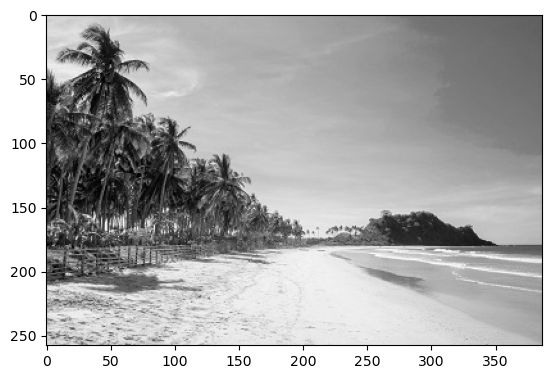

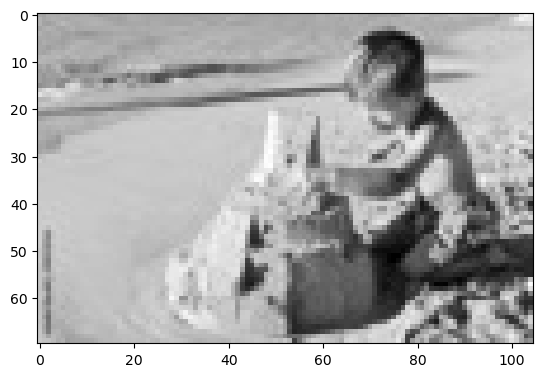

In [84]:
plot_gray_image(initial_image);
plot_gray_image(new_image);

In [85]:
def set_rectangle(point,width,height):
    vertices = [point,(point[0],point[1]+height),(point[0]+width,point[1]+height),(point[0]+width,point[1]),point]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY,]
    path = Path(vertices, codes)
    return path;

In [86]:
def draw_rectangle(path,image):
    fig, ax = plt.subplots()
    patch = patches.PathPatch(path, facecolor='blue', lw=2)
    ax.add_patch(patch)
    plt.imshow(image,alpha = 0.5);
    plt.show()

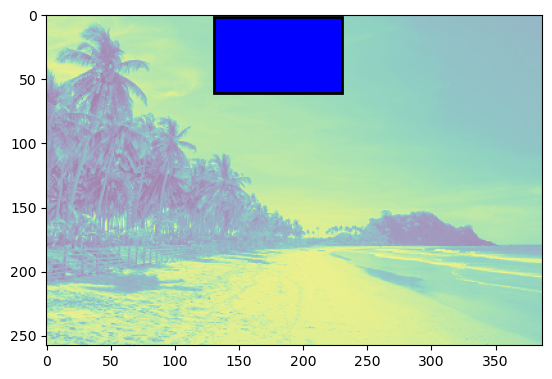

In [87]:
rectangle = set_rectangle((130,1),100,60);
draw_rectangle(rectangle,initial_image);

#### b)  Remove the selected region and fill it in:

In [88]:
def remove_rectangle(image,point,width,height):
    n,m = image.shape
    removed_image = np.zeros((n,m))
    mask1 = np.ones(point[0])
    mask2 = np.zeros(width)
    mask3 = np.ones(m-point[0]-width)
    mask = np.concatenate((mask1,mask2,mask3))
    for idx,row in enumerate(image):
        if(idx>=point[1]+height or idx<point[1]):
            removed_image[idx] = row
        else:
            removed_image[idx] = row*mask
    return removed_image

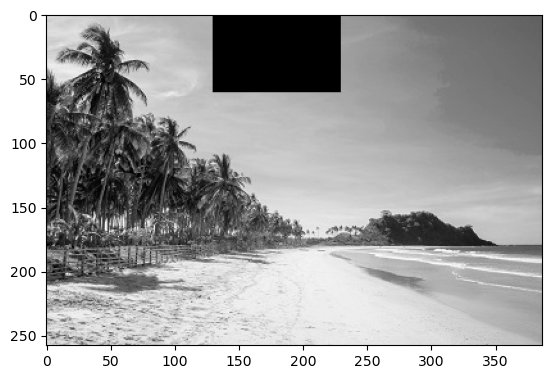

In [89]:
removed_image = remove_rectangle(initial_image,(130,1),100,60)
plot_gray_image(removed_image)

In [90]:
def restore_image(image,point,width,height,broken_image=np.array([[]])):
    size = width*height
    A = np.zeros((size,size),dtype=int)
    b = np.zeros(size,dtype=int)
    for i in tqdm(range(size)):
        A[i,i] = 4;
        k1 = i//width;
        k2 = i%width;
        ax = point[0]+k2;
        ay = point[1]+k1;
        if((ax+1) >= point[0] and (ax+1) < (point[0]+width) and ay >= point[1] and ay < (point[1]+height)):
            A[i,i+1] = -1;
        if((ax-1) >= point[0] and (ax-1) < (point[0]+width) and ay >= point[1] and ay < (point[1]+height)):
            A[i,i-1] = -1;
        if(ax >= point[0] and ax<(point[0]+width) and (ay+1) >= point[1] and (ay+1) < (point[1]+height)):
            A[i,i+width] = -1;
        if(ax >= point[0] and ax < (point[0]+width) and (ay-1) >= point[1] and (ay-1) < (point[1]+height)):
            A[i,i-width] = -1;
        if((ax+1) == point[0]+width):
            b[i] = b[i] + image[ay,ax+1]
        if((ax-1) == point[0]-1):
            b[i] = b[i] + image[ay,ax-1]
        if((ay+1) == point[1]+height):
            b[i] = b[i] + image[ay+1,ax]
        if((ay-1) == point[1]-1):
            b[i] = b[i] + image[ay-1,ax]
            
    x = np.linalg.solve(A, b)
    x = np.clip(x,0,255)
    if(broken_image.size==0):
        restored_image = image.copy()
    else:
        restored_image = broken_image.copy();
    k=0;
    for i in range(height):
        for j in range(width):
            restored_image[point[1]+i,point[0]+j] = x[k]
            k=k+1   
    return restored_image

  0%|          | 0/6000 [00:00<?, ?it/s]

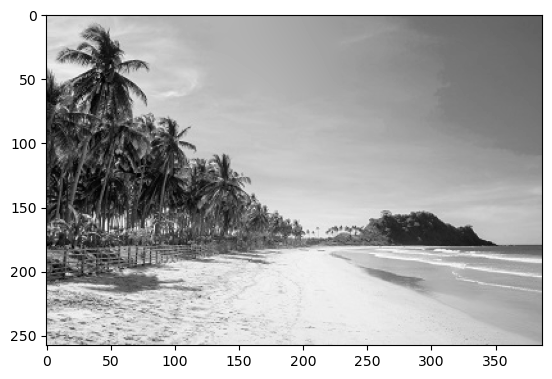

In [91]:
restored_image_1 = restore_image(removed_image,(130,1),100,60);
plot_gray_image(restored_image_1);

#### c)  Test the method in smooth regions and also in regions with edges (high-frequency):

  0%|          | 0/1500 [00:00<?, ?it/s]

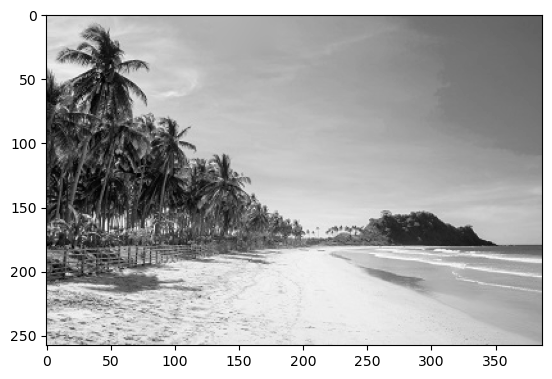

3.6133333333333333


In [92]:
restored_image_2 = restore_image(initial_image,(130,1),50,30);
plot_gray_image(restored_image_2);
print(np.sum((restored_image_2-initial_image)**2)/1500);

  0%|          | 0/1500 [00:00<?, ?it/s]

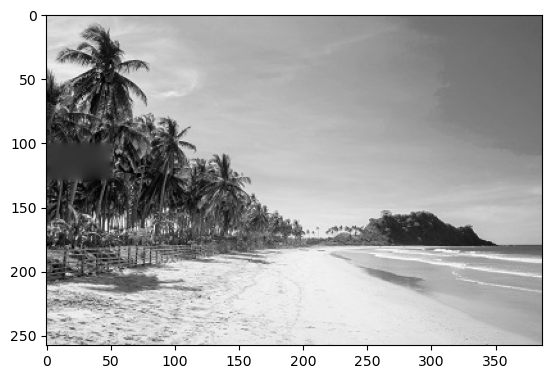

98.02333333333333


In [93]:
restored_image_3 = restore_image(initial_image,(1,100),50,30);
plot_gray_image(restored_image_3);
print(np.sum((restored_image_3-initial_image)**2)/1500);

Similarly as d), when applying (2), we consider that the gradient of the patch is 0. Therefore, we lose the information encoded in the gradient about the image. The smoother the region, the less information is encoded in the pixels, however if the region has a lots of edges, then the information is lost and the picture becomes blurry. We can see this by computing the average error of the pixels in the patche, which have equal sizes, the first one is in the area of the sky(smooth), and the second one is in an area with trees and leaves(edges). We can see that the second error is much bigger than the first.

#### d)  Report the behavior as the size of the selected region increases:

  0%|          | 0/1500 [00:00<?, ?it/s]

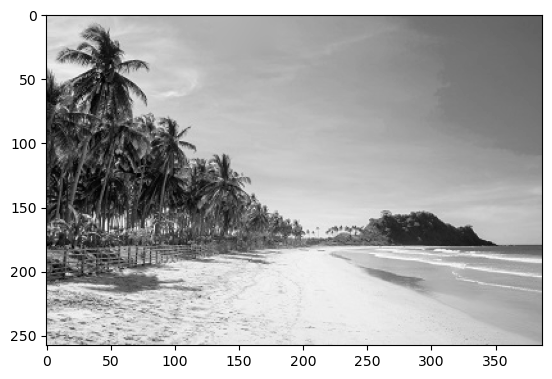

3.6133333333333333


In [94]:
restored_image_4 = restore_image(initial_image,(130,1),50,30);
plot_gray_image(restored_image_4);
print(np.sum((restored_image_4-initial_image)**2)/1500);

  0%|          | 0/6000 [00:00<?, ?it/s]

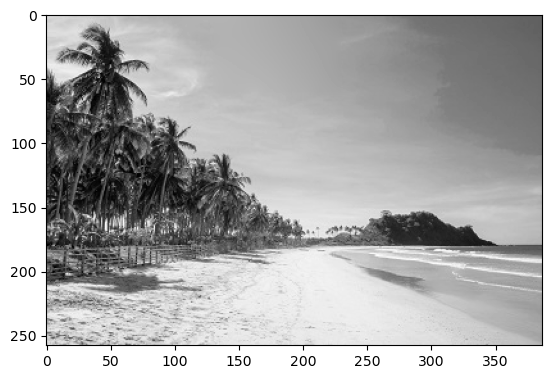

8.184666666666667


In [95]:
restored_image_5 = restore_image(initial_image,(130,1),100,60);
plot_gray_image(restored_image_5);
print(np.sum((restored_image_5-initial_image)**2)/6000);

  0%|          | 0/20000 [00:00<?, ?it/s]

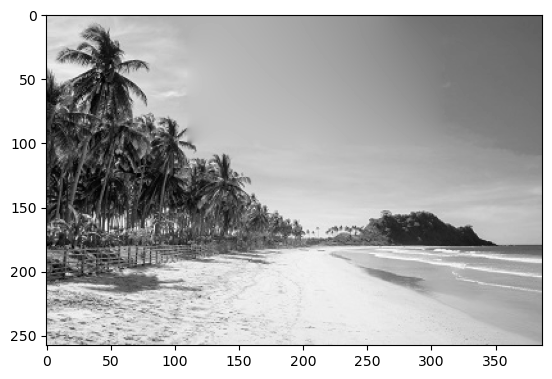

15.9885


In [97]:
restored_image_6 = restore_image(initial_image,(110,1),200,100);
plot_gray_image(restored_image_6);
print(np.sum((restored_image_6-initial_image)**2)/20000);

As the size increases, the patch becomes more and more blurry. Also, the edges where the patch is applied on the initial image are more observable. That is because when applying (2), we consider that the gradient of the patch is 0. Therefore, we lose the information encoded in the gradient about the image. The more pixels get replaced, the more information is lost and therefore the image is less and less accurate. We can see this by computing the average error of the pixels in the patches. As the patch size increases, so does the error.

## Part 2 - Seamless cloning for grayscale images:

### a) Importing gradients:

In [98]:
initial_image = read_gray_image("./pictures/beach6.jpg");
new_image = read_gray_image("./pictures/copil.jpg");

In [99]:
def import_gradients(initial_image,new_image,initial_point,new_point,width,height):
    size = width*height
    A = np.zeros((size,size),dtype=int)
    b = np.zeros(size,dtype=int)
    for i in tqdm(range(size)):
        A[i,i] = 4;
        k1 = i//width;
        k2 = i%width;
        ax = initial_point[0]+k2;
        ay = initial_point[1]+k1;
        if((ax+1) >= initial_point[0] and (ax+1) < (initial_point[0]+width) and ay >= initial_point[1] and ay < (initial_point[1]+height)):
            A[i,i+1] = -1;
        if((ax-1) >= initial_point[0] and (ax-1) < (initial_point[0]+width) and ay >= initial_point[1] and ay < (initial_point[1]+height)):
            A[i,i-1] = -1;
        if(ax >= initial_point[0] and ax<(initial_point[0]+width) and (ay+1) >= initial_point[1] and (ay+1) < (initial_point[1]+height)):
            A[i,i+width] = -1;
        if(ax >= initial_point[0] and ax < (initial_point[0]+width) and (ay-1) >= initial_point[1] and (ay-1) < (initial_point[1]+height)):
            A[i,i-width] = -1;
        if((ax+1) == initial_point[0]+width):
            b[i] = b[i] + initial_image[ay,ax+1]
        if((ax-1) == initial_point[0]-1):
            b[i] = b[i] + initial_image[ay,ax-1]
        if((ay+1) == initial_point[1]+height):
            b[i] = b[i] + initial_image[ay+1,ax]
        if((ay-1) == initial_point[1]-1):
            b[i] = b[i] + initial_image[ay-1,ax]
        nx = new_point[0]+k2;
        ny = new_point[1]+k1;
        b[i] = b[i] + 4*new_image[ny,nx] - new_image[ny-1,nx] - new_image[ny+1,nx] - new_image[ny,nx-1] - new_image[ny,nx+1]
            
    x = np.linalg.solve(A, b)
    x = np.clip(x,0,255)
    restored_image = initial_image.copy()
    k=0;
    for i in range(height):
        for j in range(width):
            restored_image[initial_point[1]+i,initial_point[0]+j] = x[k]
            k=k+1   
    return restored_image

  0%|          | 0/6000 [00:00<?, ?it/s]

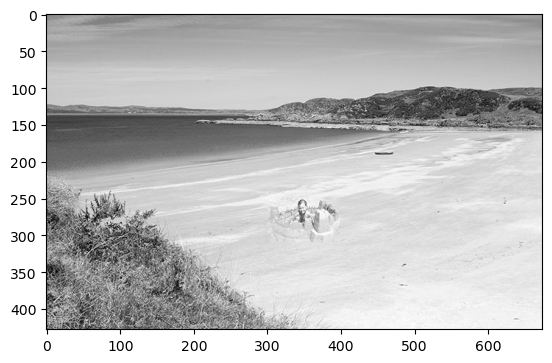

In [100]:
constructed_image_1 = import_gradients(initial_image,new_image,(300,250),(2,2),100,60);
plot_gray_image(constructed_image_1);

### b) Mixing gradients:

In [101]:
def mix_gradients(initial_image,new_image,initial_point,new_point,width,height):
    size = width*height
    A = np.zeros((size,size),dtype=int)
    b = np.zeros(size,dtype=int)
    for i in tqdm(range(size)):
        A[i,i] = 4;
        k1 = i//width;
        k2 = i%width;
        ax = initial_point[0]+k2;
        ay = initial_point[1]+k1;
        if((ax+1) >= initial_point[0] and (ax+1) < (initial_point[0]+width) and ay >= initial_point[1] and ay < (initial_point[1]+height)):
            A[i,i+1] = -1;
        if((ax-1) >= initial_point[0] and (ax-1) < (initial_point[0]+width) and ay >= initial_point[1] and ay < (initial_point[1]+height)):
            A[i,i-1] = -1;
        if(ax >= initial_point[0] and ax<(initial_point[0]+width) and (ay+1) >= initial_point[1] and (ay+1) < (initial_point[1]+height)):
            A[i,i+width] = -1;
        if(ax >= initial_point[0] and ax < (initial_point[0]+width) and (ay-1) >= initial_point[1] and (ay-1) < (initial_point[1]+height)):
            A[i,i-width] = -1;
        if((ax+1) == initial_point[0]+width):
            b[i] = b[i] + initial_image[ay,ax+1]
        if((ax-1) == initial_point[0]-1):
            b[i] = b[i] + initial_image[ay,ax-1]
        if((ay+1) == initial_point[1]+height):
            b[i] = b[i] + initial_image[ay+1,ax]
        if((ay-1) == initial_point[1]-1):
            b[i] = b[i] + initial_image[ay-1,ax]
        nx = new_point[0]+k2;
        ny = new_point[1]+k1;
        if(abs(int(new_image[ny,nx]) - int(new_image[ny-1,nx])) > abs(int(initial_image[ay,ax]) - int(initial_image[ay-1,ax]))):
            b[i] = b[i] + new_image[ny,nx] - new_image[ny-1,nx];
        else:
            b[i] = b[i] + initial_image[ay,ax] - initial_image[ay-1,ax];
        if(abs(int(new_image[ny,nx]) - int(new_image[ny+1,nx])) > abs(int(initial_image[ay,ax]) - int(initial_image[ay+1,ax]))):
            b[i] = b[i] + new_image[ny,nx] - new_image[ny+1,nx];
        else:
            b[i] = b[i] + initial_image[ay,ax] - initial_image[ay+1,ax];
        if(abs(int(new_image[ny,nx]) - int(new_image[ny,nx-1])) > abs(int(initial_image[ay,ax]) - int(initial_image[ay,ax-1]))):
            b[i] = b[i] + new_image[ny,nx] - new_image[ny,nx-1];
        else:
            b[i] = b[i] + initial_image[ay,ax] - initial_image[ay,ax-1];
        if(abs(int(new_image[ny,nx]) - int(new_image[ny,nx+1])) > abs(int(initial_image[ay,ax]) - int(initial_image[ay,ax+1]))):
            b[i] = b[i] + new_image[ny,nx] - new_image[ny,nx+1];
        else:
            b[i] = b[i] + initial_image[ay,ax] - initial_image[ay,ax+1];
#         b[i] = b[i] + 4*new_image[ny,nx] - new_image[ny-1,nx] - new_image[ny+1,nx] - new_image[ny,nx-1] - new_image[ny,nx+1]
            
    x = np.linalg.solve(A, b)
    x = np.clip(x,0,255)
    restored_image = initial_image.copy()
    k=0;
    for i in range(height):
        for j in range(width):
            restored_image[initial_point[1]+i,initial_point[0]+j] = x[k]
            k=k+1   
    return restored_image

  0%|          | 0/6000 [00:00<?, ?it/s]

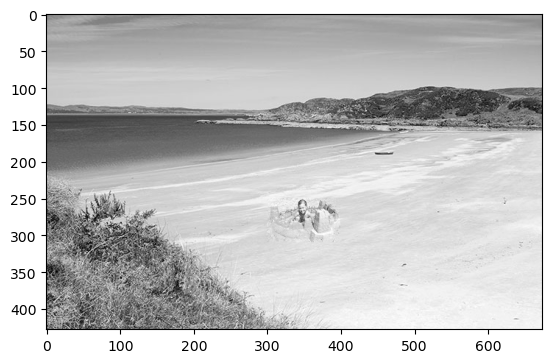

In [102]:
constructed_image_2 = mix_gradients(initial_image,new_image,(300,250),(2,2),100,60);
plot_gray_image(constructed_image_2);

### c) Select two images and show result that demonstrated well the effect with one sentence of explanation for each:

  0%|          | 0/6000 [00:00<?, ?it/s]

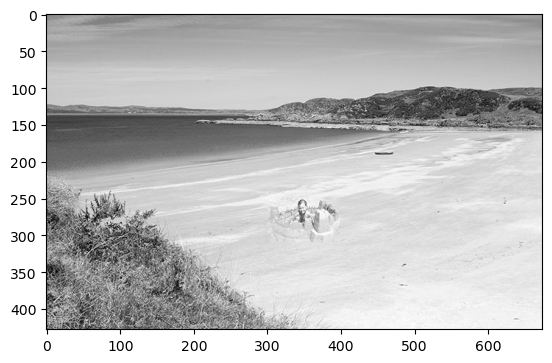

In [103]:
constructed_image_3 = import_gradients(initial_image,new_image,(300,250),(2,2),100,60);
plot_gray_image(constructed_image_3);

In this photo we have our initial photo of an empty beach, and our photo of a child playing in an sandcastle, since the gradient of the empty beach is close to 0 (there are no edges), when using the information of the gradient of the new image, the patch we created seems realistic. 

In [104]:
triangle_image = read_gray_image("./pictures/triangle.jpg");
fill_image = read_gray_image("./pictures/fill.jpg");
hash_image = read_gray_image("./pictures/hash.jpg");

  0%|          | 0/12100 [00:00<?, ?it/s]

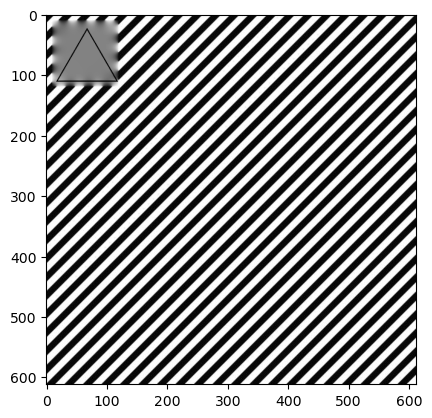

In [105]:
constructed_image_4 = import_gradients(hash_image,triangle_image,(10,10),(2,2),110,110);
plot_gray_image(constructed_image_4);

  0%|          | 0/12100 [00:00<?, ?it/s]

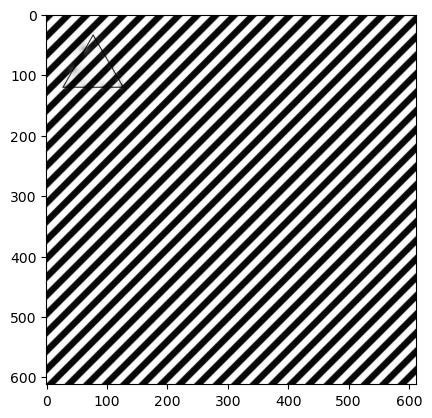

In [106]:
constructed_image_5 = mix_gradients(hash_image,triangle_image,(20,20),(2,2),110,110);
plot_gray_image(constructed_image_5);

Here we can see the effect of mixing gradients, our background image is striped and the image we are trying to patch is just a black triangle on a white background, When using the importing gradients method we note that since all the details about the background gradient is lost, we get a blurry background for the patch(the gradient of the imported image there is 0, the white background),but the triangle is stil visible, however when importing gradients, the triangle is still well defined(the gradient has a big value, while the background gets imported from the initial image.

  0%|          | 0/12100 [00:00<?, ?it/s]

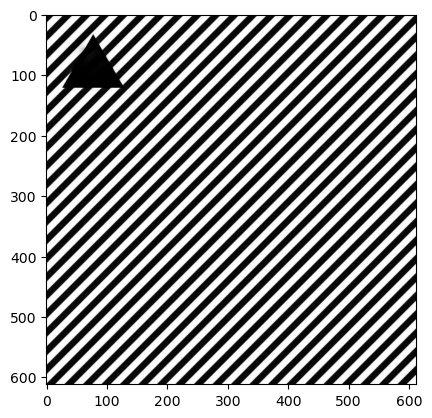

In [107]:
constructed_image_6 = mix_gradients(hash_image,fill_image,(20,20),(2,2),110,110);
plot_gray_image(constructed_image_6);

## Part 3 - Seamless cloning for color images:

In [108]:
def read_color_picture(path):
    img = cv2.imread(path);
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB);
    return img;

In [109]:
def plot_image(image):
    plt.imshow(image)
    plt.show()

In [110]:
initial_color_image = read_color_picture("./pictures/beach6.jpg");
new_color_image = read_color_picture("./pictures/copil.jpg");

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

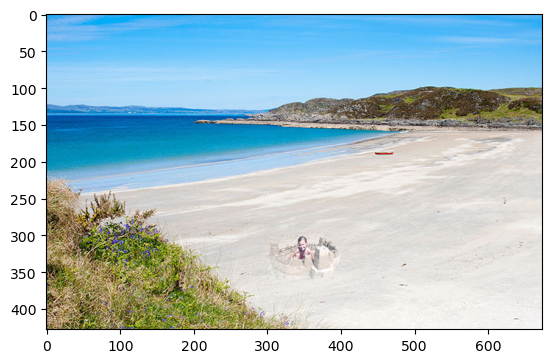

In [111]:
constructed_image_i = import_gradients(initial_color_image[:,:,0],new_color_image[:,:,0],(300,300),(2,2),100,60);
constructed_image_ii = import_gradients(initial_color_image[:,:,1],new_color_image[:,:,1],(300,300),(2,2),100,60);
constructed_image_iii = import_gradients(initial_color_image[:,:,2],new_color_image[:,:,2],(300,300),(2,2),100,60);
constructed_image_7 = cv2.merge([constructed_image_i,constructed_image_ii,constructed_image_iii]);
plot_image(constructed_image_7);

## Part 4 - Local color changes:

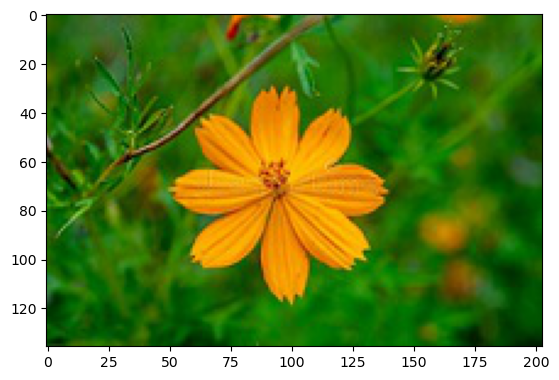

In [112]:
initial_image = read_gray_image("./pictures/flower.jpg");  #or a color image with changed colors
new_color_image = read_color_picture("./pictures/flower.jpg"); 
plot_image(new_color_image)

  0%|          | 0/8100 [00:00<?, ?it/s]

  0%|          | 0/8100 [00:00<?, ?it/s]

  0%|          | 0/8100 [00:00<?, ?it/s]

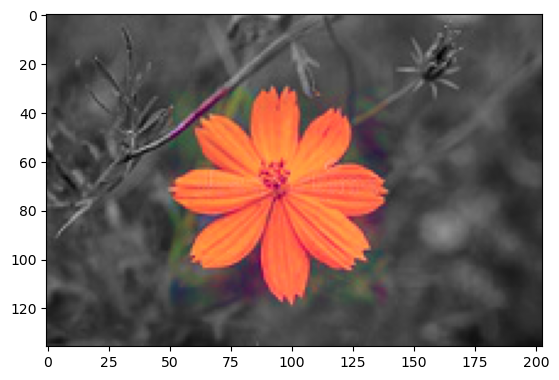

In [113]:
constructed_image_i = import_gradients(initial_image,new_color_image[:,:,0],(50,30),(50,30),90,90);
constructed_image_ii = import_gradients(initial_image,new_color_image[:,:,1],(50,30),(50,30),90,90);
constructed_image_iii = import_gradients(initial_image,new_color_image[:,:,2],(50,30),(50,30),90,90);
constructed_image_8 = cv2.merge([constructed_image_i,constructed_image_ii,constructed_image_iii]);
plot_image(constructed_image_8);

In [114]:
initial_color_image = read_color_picture("./pictures/flower.jpg");  #or a color image with changed colors
new_color_image = read_color_picture("./pictures/flower.jpg"); 
new_color_image[:,:,2] = 1.5*new_color_image[:,:,2];
new_color_image[:,:,1] = 0.5*new_color_image[:,:,1];

  0%|          | 0/8100 [00:00<?, ?it/s]

  0%|          | 0/8100 [00:00<?, ?it/s]

  0%|          | 0/8100 [00:00<?, ?it/s]

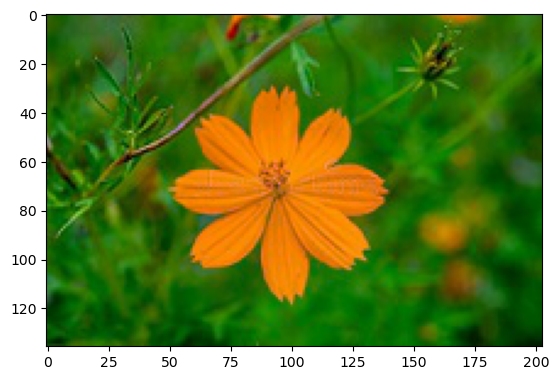

In [115]:
constructed_image_i = import_gradients(initial_color_image[:,:,0],new_color_image[:,:,0],(50,30),(50,30),90,90);
constructed_image_ii = import_gradients(initial_color_image[:,:,1],new_color_image[:,:,1],(50,30),(50,30),90,90);
constructed_image_iii = import_gradients(initial_color_image[:,:,2],new_color_image[:,:,2],(50,30),(50,30),90,90);
constructed_image_9 = cv2.merge([constructed_image_i,constructed_image_ii,constructed_image_iii]);
plot_image(constructed_image_9);